# Block processing

Estimating the impulse response by doing estimation on multiple blocks of time and aggregating the separate block results into a combined impulse response (e.g. averaging, median, etc.)

Resources:
- [Cuki’s IR generator Light](http://acousticir.free.fr/spip.php?article169)

In [1]:
import time

import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf

import scipy.signal

In [2]:
INPUT_FILE = "data/martin_dcx1re_c414_left_pickup_right.wav"

In [3]:
data, sample_rate_Hz = sf.read(INPUT_FILE)
ydata, xdata = data.T

## Naive deconvolution

In [8]:
w = np.blackman(len(xdata))
X = np.fft.fft(w * xdata, 2048)
Y = np.fft.fft(w * ydata, 2048)
H_naive = Y/X

## Deconvolution using block processing

In [19]:
def freqresp(H, fig, ax1, ax2):
    f = np.linspace(0, sample_rate_Hz, len(H))
    end = len(f)//2
    f_ = f[0:end]
    ax1.semilogx(f_, 20*np.log10(np.abs(H[0:end])))
    ax2.semilogx(f_, np.rad2deg(np.unwrap(np.angle(H[0:end]))))
      
    for ax in (ax1, ax2):
        ax.grid()
    fig.tight_layout()

    return fig, ax

def estimate_frequency_response(x, y, size=None):
    if size is None:
        size = len(x)
    w = np.blackman(len(x))
    X = np.fft.fft(x * w, size)
    Y = np.fft.fft(y * w, size)
    H = Y/X
    return H

def block_generator(xdata, ydata, size):
    N = len(xdata)
    assert N == len(xdata) == len(ydata)
    for n in range(0, N, size):
        start = n
        stop = n + size
        if stop > N:
            break
        yield xdata[start:stop], ydata[start:stop]

L = 2048

H_blocks = np.array([
    estimate_frequency_response(x, y)
    for x, y in block_generator(xdata, ydata, L)
])

In [20]:
H_abs = np.median(np.abs(H_blocks), axis=0)
H_ang = np.median(np.unwrap(np.angle(H_blocks)), axis=0)
H = H_abs * np.exp(1j*H_ang)

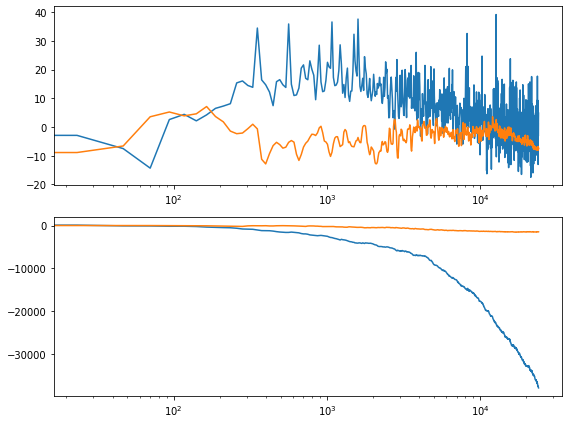

In [23]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))

freqresp(H_naive, fig, ax1, ax2)
freqresp(H, fig, ax1, ax2)
pass

## Impulse response

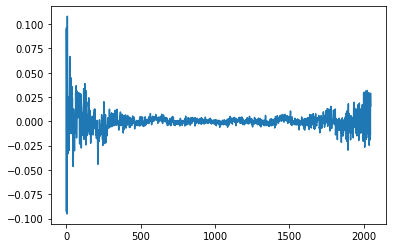

In [22]:
h = np.real(np.fft.ifft(H))
plt.plot(h)
# sf.write(f"ir_{int(time.time())}.wav", h, samplerate=sample_rate_Hz)

## Conclusion

This does not look correct. There is almost no frequency-dependency except at DC.